In [1]:

import json
import glob
import numpy

import fiftyone as fo

from fiftyone import ViewField as F

#from PIL import Image

from ghop_utils import *

## Visualizamos el dataset

Con objeto de mejorar el entrenamiento, se ignora el dataset de Producto donde la clase objetivo se encuentra demasiado aislada y descontextualizada. 
En el json de labels de Varios, aunque el objeto "Categories" tan sólo contiene la clase correspondiente al producto en cuestion (111_canned_food), es posible extenderlo usando el resto de detecciones de diferentes categorias registradas en el mismo.

La herramienta elegida para poder visualizar y mejorar el proceso de entrenamiento es la herramienta Open Source FiftyOne de Voxel51:

https://github.com/voxel51/fiftyone

In [2]:
# Aprovechamos que el dataset sigue el estándar de definición de datos de COCO.
# re-populamos el objeto Categories del json del dataset de Varios a partir de las categorias disponibles
# en el objeto annotations y las volcamos en el archivo labels.json

filename = '/dataset/labels.json'
with open('/dataset/labels_in.json', 'r') as f:
    data = json.load(f)

annotations = data['annotations']
categories_json = data['categories']
# Create samples for your data
samples = []
categories = []
count = 0

for obj in annotations:
    categories.append(obj["category_id"])
    
for category in numpy.unique(categories):
    data['categories'].append({
        'supercategory': 'canned_food', 
        'id': int(category), 
        'name': f'{category}_canned_food'})

with open(filename, 'w') as json_file:
    json.dump(data, json_file)

    

In [3]:
# Cargamos las etiquetas de ground truth en un subset del anterior dataset
dataset_various = fo.Dataset.from_dir(
    dataset_dir="/dataset/",
    dataset_type=fo.types.COCODetectionDataset,
    label_field="ground_truth",
    name="varios"
)

 100% |███████████████| 1000/1000 [8.4s elapsed, 0s remaining, 75.7 samples/s]       



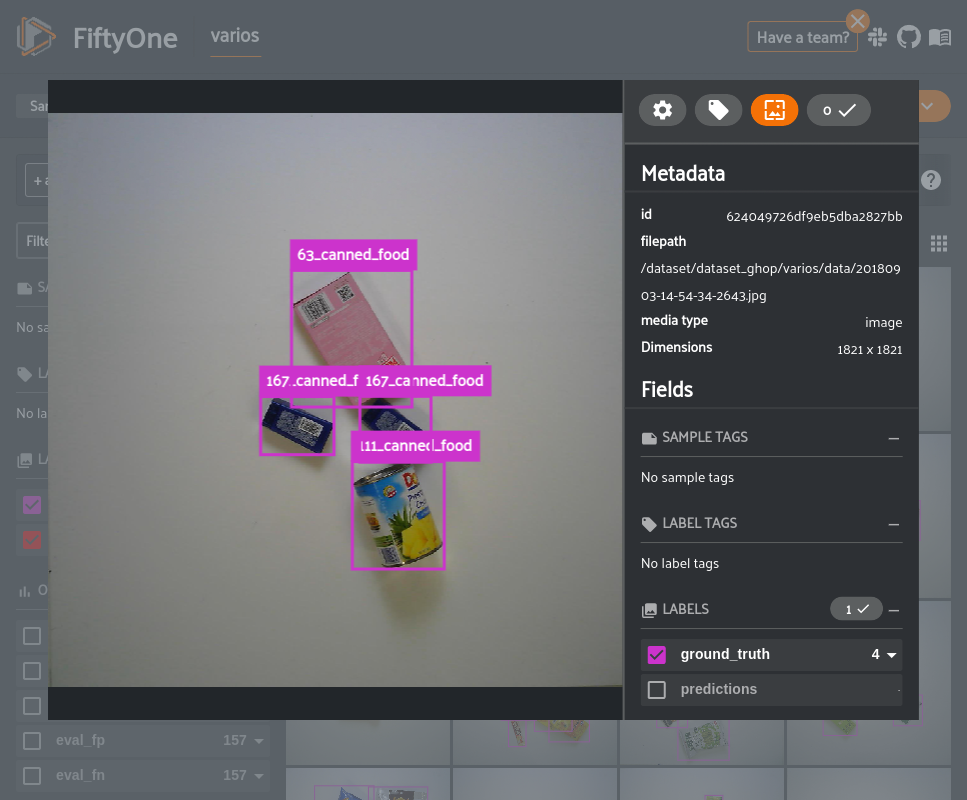

In [4]:
# Visualizamos el dataset
session = fo.launch_app(dataset_various)

# Preparamos el modelo

Usando la capacidad de FiftyOne para generar subsets, aplicamos un filtro para recoger las imagenes donde se encuentren las etiquetas correspondientes a 111_canned_food, la categoría que nos interesa.
Posteriormente, podremos generar los subsets de test y training.

In [5]:
detections_view = dataset_various.match(F("ground_truth.detections").length() > 5)

objects_list = ['111_canned_food']
objects_view = detections_view.filter_labels("ground_truth", F("label").is_in(objects_list))

total_samples = len(detections_view)

print("Search items:")
for item in objects_list:
    print(item)
    
print("Total instances found:", total_samples)


Search items:
111_canned_food
Total instances found: 937


In [6]:
# From the torchvision references we cloned

train_transforms = T.Compose([T.ToTensor(), T.RandomHorizontalFlip(0.5)])
test_transforms = T.Compose([T.ToTensor()])

In [7]:
# split the dataset in train and test set
train_view = objects_view.take(total_samples * 0.35, seed=51)
test_view = objects_view.exclude([s.id for s in train_view])
print('Train samples:', len(train_view), ' / Test samples:', len(test_view))

Train samples: 327  / Test samples: 157


In [8]:
# use our dataset and defined transformations

scaler = 0.5

torch_dataset = FiftyOneTorchDataset(train_view, 
                                     train_transforms,
                                     classes=objects_list,
                                     scaler=scaler)

torch_dataset_test = FiftyOneTorchDataset(test_view,
                                          test_transforms,
                                          classes=objects_list,
                                          scaler=scaler)

## Entrenamos el modelo

El modelo elegido por cuestiones de capacidad de tajeta gráfica ha sido el fasterrcnn_mobilenet_v3_large_320_fpn disponible PyTorch.
Se ha hecho alguna optimización para agilizar el entrenamiento (reescalado a la mitad de las imágenes), ya que tenían resoluciones de 1810x1810, y los bounding boxes presentan tamaños de no menos de ~80px.

Para entrenar, el propio paquete de PyTorch facilita diversos optimizadores que se pueden aplicar en esta arquitectura. 
Por simplicidad, nos limitaremos a un Stochastic Gradient Descent con un learning rate inicializado a 0.005. Posteriormente usaremos un scheduler para afinarlo a medida que las epocas avanzan y el modelo gana en precisión:

    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                    step_size=3,
                                                    gamma=0.1)

También por simplicidad, se han limitado el número de épocas a 4, ya que daba resultados mínimamente aceptables como prueba de concepto.

In [9]:
num_classes = len(objects_list) + 1
model = get_model(num_classes)

Using device cuda:0
Model ready


In [10]:
do_training(model, torch_dataset, torch_dataset_test, num_epochs=4)

Using device cuda
327
Epoch: [0]  [  0/327]  eta: 0:03:48  lr: 0.000020  loss: 0.7967 (0.7967)  loss_classifier: 0.6495 (0.6495)  loss_box_reg: 0.1006 (0.1006)  loss_objectness: 0.0462 (0.0462)  loss_rpn_box_reg: 0.0005 (0.0005)  time: 0.6995  data: 0.0835  max mem: 275
Epoch: [0]  [ 10/327]  eta: 0:04:16  lr: 0.000174  loss: 0.9355 (0.9224)  loss_classifier: 0.6495 (0.6417)  loss_box_reg: 0.1053 (0.2083)  loss_objectness: 0.0618 (0.0677)  loss_rpn_box_reg: 0.0043 (0.0047)  time: 0.8103  data: 0.0711  max mem: 338
Epoch: [0]  [ 20/327]  eta: 0:03:52  lr: 0.000327  loss: 0.6993 (0.7436)  loss_classifier: 0.4460 (0.4859)  loss_box_reg: 0.1618 (0.1968)  loss_objectness: 0.0517 (0.0569)  loss_rpn_box_reg: 0.0035 (0.0041)  time: 0.7598  data: 0.0691  max mem: 338
Epoch: [0]  [ 30/327]  eta: 0:03:36  lr: 0.000480  loss: 0.6113 (0.7426)  loss_classifier: 0.3654 (0.4734)  loss_box_reg: 0.2028 (0.2144)  loss_objectness: 0.0390 (0.0509)  loss_rpn_box_reg: 0.0028 (0.0040)  time: 0.6821  data: 0.0

Epoch: [0]  [326/327]  eta: 0:00:00  lr: 0.005000  loss: 0.7547 (0.8449)  loss_classifier: 0.2712 (0.3203)  loss_box_reg: 0.3764 (0.4972)  loss_objectness: 0.0208 (0.0240)  loss_rpn_box_reg: 0.0024 (0.0035)  time: 0.6673  data: 0.0707  max mem: 338
Epoch: [0] Total time: 0:03:27 (0.6339 s / it)
creating index...
index created!
Test:  [  0/157]  eta: 0:00:32  model_time: 0.1346 (0.1346)  evaluator_time: 0.0012 (0.0012)  time: 0.2095  data: 0.0698  max mem: 338
Test:  [100/157]  eta: 0:00:14  model_time: 0.1932 (0.1811)  evaluator_time: 0.0019 (0.0019)  time: 0.2666  data: 0.0646  max mem: 338
Test:  [156/157]  eta: 0:00:00  model_time: 0.2128 (0.2286)  evaluator_time: 0.0021 (0.0020)  time: 0.3790  data: 0.0672  max mem: 338
Test: Total time: 0:00:47 (0.3000 s / it)
Averaged stats: model_time: 0.2128 (0.2286)  evaluator_time: 0.0021 (0.0020)
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.208

Epoch: [1]  [260/327]  eta: 0:00:39  lr: 0.005000  loss: 0.5959 (0.9574)  loss_classifier: 0.2034 (0.2946)  loss_box_reg: 0.3606 (0.6459)  loss_objectness: 0.0126 (0.0139)  loss_rpn_box_reg: 0.0024 (0.0029)  time: 0.6122  data: 0.0714  max mem: 360
Epoch: [1]  [270/327]  eta: 0:00:33  lr: 0.005000  loss: 0.9146 (0.9723)  loss_classifier: 0.2352 (0.2977)  loss_box_reg: 0.6991 (0.6582)  loss_objectness: 0.0052 (0.0137)  loss_rpn_box_reg: 0.0024 (0.0028)  time: 0.4986  data: 0.0713  max mem: 360
Epoch: [1]  [280/327]  eta: 0:00:27  lr: 0.005000  loss: 1.0872 (0.9762)  loss_classifier: 0.2301 (0.2956)  loss_box_reg: 0.8139 (0.6644)  loss_objectness: 0.0038 (0.0134)  loss_rpn_box_reg: 0.0016 (0.0028)  time: 0.4638  data: 0.0712  max mem: 360
Epoch: [1]  [290/327]  eta: 0:00:21  lr: 0.005000  loss: 0.9267 (0.9740)  loss_classifier: 0.2263 (0.2956)  loss_box_reg: 0.6275 (0.6621)  loss_objectness: 0.0063 (0.0134)  loss_rpn_box_reg: 0.0024 (0.0028)  time: 0.4929  data: 0.0709  max mem: 360
Epoc

Epoch: [2]  [190/327]  eta: 0:01:19  lr: 0.005000  loss: 0.7725 (0.8779)  loss_classifier: 0.2403 (0.2604)  loss_box_reg: 0.5147 (0.6048)  loss_objectness: 0.0039 (0.0101)  loss_rpn_box_reg: 0.0018 (0.0026)  time: 0.4934  data: 0.0699  max mem: 360
Epoch: [2]  [200/327]  eta: 0:01:13  lr: 0.005000  loss: 0.7816 (0.8740)  loss_classifier: 0.1919 (0.2583)  loss_box_reg: 0.5776 (0.6032)  loss_objectness: 0.0040 (0.0099)  loss_rpn_box_reg: 0.0024 (0.0026)  time: 0.4851  data: 0.0702  max mem: 360
Epoch: [2]  [210/327]  eta: 0:01:07  lr: 0.005000  loss: 0.8113 (0.8743)  loss_classifier: 0.1780 (0.2541)  loss_box_reg: 0.5957 (0.6079)  loss_objectness: 0.0040 (0.0097)  loss_rpn_box_reg: 0.0029 (0.0026)  time: 0.5160  data: 0.0732  max mem: 360
Epoch: [2]  [220/327]  eta: 0:01:02  lr: 0.005000  loss: 0.9821 (0.8835)  loss_classifier: 0.1714 (0.2522)  loss_box_reg: 0.7799 (0.6193)  loss_objectness: 0.0040 (0.0094)  loss_rpn_box_reg: 0.0032 (0.0026)  time: 0.6135  data: 0.0761  max mem: 360
Epoc

Epoch: [3]  [120/327]  eta: 0:01:54  lr: 0.000500  loss: 0.5141 (0.5851)  loss_classifier: 0.1504 (0.1732)  loss_box_reg: 0.3554 (0.3989)  loss_objectness: 0.0073 (0.0105)  loss_rpn_box_reg: 0.0025 (0.0025)  time: 0.5052  data: 0.0720  max mem: 360
Epoch: [3]  [130/327]  eta: 0:01:48  lr: 0.000500  loss: 0.4315 (0.5704)  loss_classifier: 0.0969 (0.1664)  loss_box_reg: 0.3179 (0.3916)  loss_objectness: 0.0056 (0.0101)  loss_rpn_box_reg: 0.0010 (0.0024)  time: 0.5100  data: 0.0711  max mem: 360
Epoch: [3]  [140/327]  eta: 0:01:42  lr: 0.000500  loss: 0.4377 (0.5786)  loss_classifier: 0.0746 (0.1640)  loss_box_reg: 0.3323 (0.4018)  loss_objectness: 0.0061 (0.0103)  loss_rpn_box_reg: 0.0015 (0.0025)  time: 0.5135  data: 0.0708  max mem: 360
Epoch: [3]  [150/327]  eta: 0:01:36  lr: 0.000500  loss: 0.5400 (0.5747)  loss_classifier: 0.1142 (0.1619)  loss_box_reg: 0.3807 (0.4003)  loss_objectness: 0.0061 (0.0100)  loss_rpn_box_reg: 0.0031 (0.0025)  time: 0.5095  data: 0.0719  max mem: 360
Epoc

## Añadimos las detecciones al dataset y extraemos los datos de rendimiento

Usando las herramientas facilitadas por FiftyOne, podemos evaluar el comportamiento de nuestro modelo re-entrenado

In [11]:
add_detections(model, torch_dataset_test, dataset_various, field_name="predictions", scaler=scaler)

Using device cuda
 100% |█████████████████| 157/157 [40.6s elapsed, 0s remaining, 4.0 samples/s]      


In [12]:
results = fo.evaluate_detections(
    test_view, 
    "predictions", 
    classes=["111_canned_food"], 
    eval_key="eval", 
    compute_mAP=True
)


Evaluating detections...
 100% |█████████████████| 157/157 [1.2s elapsed, 0s remaining, 136.9 samples/s]         
Performing IoU sweep...
 100% |█████████████████| 157/157 [1.1s elapsed, 0s remaining, 137.5 samples/s]         


In [13]:
results.mAP()

0.6280949302566643

In [14]:
results.print_report()

                 precision    recall  f1-score   support

111_canned_food       0.76      0.99      0.86       296

      micro avg       0.76      0.99      0.86       296
      macro avg       0.76      0.99      0.86       296
   weighted avg       0.76      0.99      0.86       296



In [21]:
plot = results.plot_pr_curves(classes=objects_list)
plot.show()

FigureWidget({
    'data': [{'customdata': array([0.99650621, 0.89569967, 0.89461687, 0.89396136, 0.89350473, …

In [15]:
# Open the dataset in the App
session = fo.launch_app(dataset=dataset_various)

# Conclusiones y reflexiones

*El objetivo final de este pequeño proyecto es que entrenes un modelo que resuelva el problema descrito antes, sólo para el producto “A”. Reporta una métrica (o métricas) adecuadas para evaluar la calidad del modelo. Por favor, explica por qué consideras esa métrica y no otra.*

Una vez evaluado el comportamiento del modelo, la métrica que posiblemente mejor defina su calidad sea la facilitada como F1 (construída a partir de la precision y el recall), ya que nos garantiza que no sólo los falsos negativos son tenidos en cuenta, si no tambien los falsos positivos.
La precision y el recall se calculan en base a la IoU (Intersection over Union) entre los bounding boxes detectados y los posibles existentes en la ground_truth, según la clase definida por el ground_truth.

En un caso de uso como el que nos ocupa (conteo de apariciones de una clase específica), no sólo se trata de aumentar las probabilidades de detectar objetos, si no también de aumentar las probabilidades de que aquello que ha sido detectado entre en la clase que le toca.

No obstante, en tanto que métricas como mAP se usan frecuentemente para comparar modelos, siempre es más efectiva la visualización sobre muestras específicas.
De esta manera es posible detectar manualmente algunos solapes y predicciones duplicadas que deberían tomarse en cuenta a la hora de efectuar el conteo.

*En cualquier caso, indica qué harías para mejorar estas métricas si estuvieras trabajando con nosotros.*

En primer lugar, aparte de los obvios ajustes al modelo (cambio por otro más potente, incremento de épocas, etc), haría un análisis más exhaustivo del dataset para verificar la necesidad de aumentarlo o no.

Por otra parte, si tenemos en cuenta la tabla de más abajo, se puede observar que no va a resultar muy fácil mejorar mucho más, dado que los mejores resultados sólo llegan a precisiones de 52.1 en el dataset de COCO con 80 categorías:

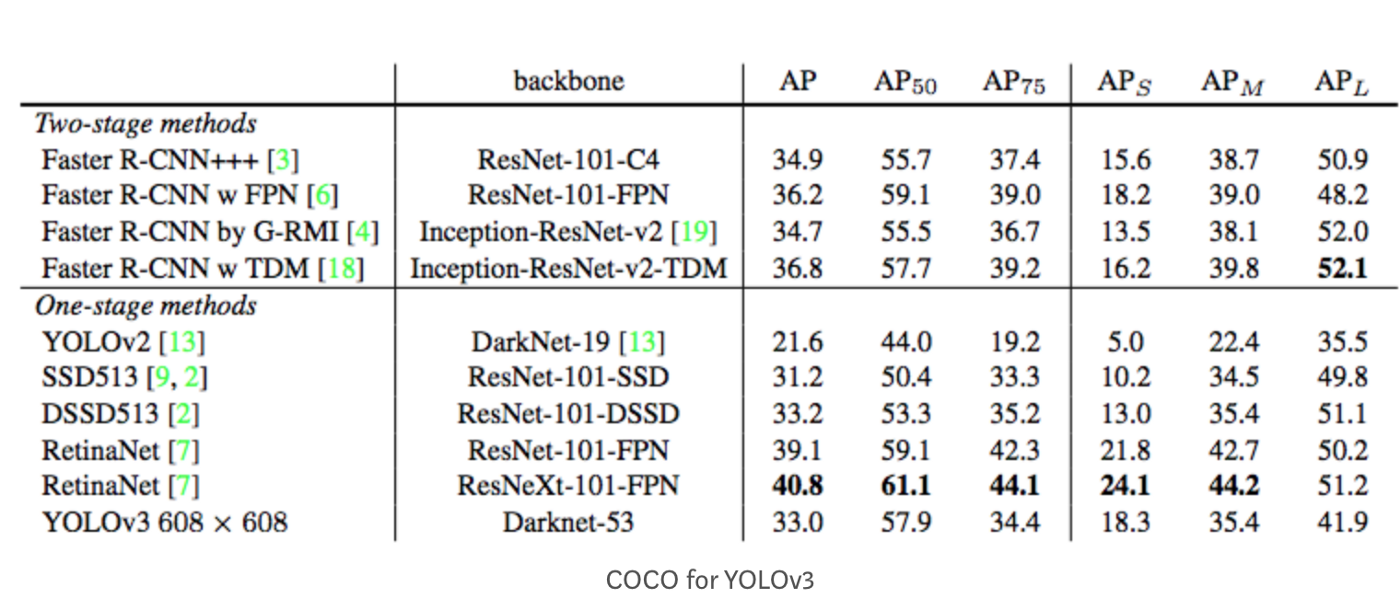


Tras sólo 4 épocas, nuestro modelo ya detecta con una mAP de ~63%.

*Finalmente, si tuviéramos que escalar este proyecto para identificar 300 productos diferentes. ¿Cómo lo harías? Redacta los pasos que seguirías y las necesidades técnicas del proyecto.*

Entiendo que añadiría más categorías a la lista definida al principio, asegurándome de que tenemos un dataset equilibrado.

